# Finding Stadiums using Sentinel 2 RGB Satellite Data

The [Sentinel-2](https://en.wikipedia.org/wiki/Sentinel-2) mission, operated by the European Space Agency (ESA), is part of the Copernicus Earth observation program. It consists of a constellation of two satellites equipped with multispectral sensors that capture data in 13 spectral bands, including the visible RGB bands. The resolution for the RGB data is 10 meters per pixel, providing a relatively detailed view of the Earth's surface.

One of the remarkable aspects of Sentinel-2 data is its open availability, making it an excellent resource for experimenting with machine learning applications. This freely accessible dataset, made possible by ESA, offers great potential for tackling various geospatial challenges.

In this notebook, we explore whether it is feasible to detect large man-made structures, specifically stadiums, using Sentinel-2 RGB data. By leveraging deep learning object detection techniques, we aim to answer the question: can we use this freely available satellite imagery to reliably identify stadiums in diverse geographic regions?



In [1]:
import ee
import geemap
import requests
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Polygon
import subprocess
from tqdm import tqdm
from shapely.geometry import Point
import torch
from torchgeo.datasets import Sentinel2, RasterDataset, stack_samples, unbind_samples
from torchgeo.samplers import RandomGeoSampler
import geopandas as gpd
from torch.utils.data import DataLoader
from torchgeo.datasets.utils import BoundingBox
import rasterio as rio
from torch.utils.data import Dataset
import warnings
import pandas as pd
from rasterio.windows import Window
import matplotlib.patches as patches
import lightning.pytorch as pl
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
from torchgeo.trainers import ObjectDetectionTask

import os

os.environ["CPL_LOG"] = "/dev/null"

data_root_path = Path.cwd().parent / "data"

/home/john/mp/stadiums2/env/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


The Sentinel imagery will be downloaded through the __Google Earth Engine__ data catalog. This requires an active google account.

In [2]:
ee.Authenticate()
ee.Initialize()

## Stadium Location Dataset

The prelabled dataset consists of geographically annotated polygons denoting the location and shape of various Stadiums and football pitches in Ireland, England, Belgium and France. It was created in three steps 

1. Several wikipedia pages listing the largest sport stadiums in different countries.
2. These stadiums were then geolocated to a specific Lat/Lon coordinate.
3. The polygons were then drawn manually in QGis using the locations obtained in previous steps.


In [3]:
geojson_path = data_root_path / "stadiums_polygons.geojson"
train_data_path = data_root_path / "sentinel2_train_data"
test_image_path = data_root_path / "sentinel2_test_data"

gdf = gpd.read_file(geojson_path)

bands = ["B4", "B3", "B2"]


def explore_sentinel2(data: Path | gpd.GeoDataFrame, bands, data_layer_name: str = ""):

    m = geemap.Map(
        center=(0, 0),
        zoom=2,
        height="1000px",
    )

    sentinel2 = (
        ee.ImageCollection("COPERNICUS/S2")
        .filterDate("2023-05-01", "2023-10-01")
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
        .median()
        .select(bands)
    )

    vis_params = {"min": 0, "max": 3000, "gamma": 0.7}

    m.addLayer(sentinel2, vis_params, "Sentinel2 RGB")

    if isinstance(data, Path):
        m.add_geojson(str(data), layer_name=data_layer_name)
    elif isinstance(data, gpd.GeoDataFrame):
        m.add_gdf(data, layer_name=data_layer_name)

    return m


print(f"Number of stadiums annotated:\t{gdf.shape[0]}")
explore_sentinel2(geojson_path, bands, "Stadiums")

Number of stadiums annotated:	128


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Download Training Data

The following code cell downloads a Sentinel 2 tif image depicting each stadium with its surroundings. The logic for selecting the image data to download is implemented using the Google Earth Engine python SDK.


In [4]:
def download_sentinel2_tiles(
    gdf,
    output_path: Path,
    bands: list,
    start_date: str = "2024-03-01",
    end_date: str = "2024-11-30",
    buffer: int = 5000,
):
    output_path.mkdir(parents=True, exist_ok=True)

    for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):

        region = ee.Geometry.Rectangle([*row.geometry.bounds]).buffer(buffer)

        image = (
            ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
            .filterBounds(region)
            .filterDate(start_date, end_date)
            .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
            .sort("CLOUDY_PIXEL_PERCENTAGE")
            .limit(5)
            .mosaic()
            .select(bands)
            .clip(region)
        )

        download_url = image.getDownloadURL(
            {"scale": 10, "region": region, "format": "GeoTIFF", "crs": "EPSG:4326"}
        )

        with (output_path / f"tile_{idx}.tif").open("wb") as io:
            response = requests.get(download_url)
            io.write(response.content)


# download_sentinel2_tiles(gdf, train_data_path, bands)

### PyTorch Compatible Dataset

To train a machine learning model we need a Pytorch dataset that converts the tif images and the raw coordinate bounding boxes into something that is comaptible with torchvision framework. The code below defines a custom dataset class, `CustomSentinel2Dataset`, for handling satellite imagery and associated bounding boxes for stadiums. The class uses GeoTIFF images and a GeoJSON file containing the bounding boxes for stadiums. It prepares data for training an object detection model by windowing each image and pairing it with the corresponding stadium bounding boxes.

The `__getitem__` function in the CustomSentinel2Dataset class is responsible for preparing individual data samples from the dataset. For each requested index, it selects the corresponding GeoTIFF image and finds the stadium locations within the image bounds. The method then calculates the image's center and applies a random offset (jitter) in both x and y directions to create some variability in the image positioning. After this, a windowed section of the image is extracted, ensuring it includes the relevant stadium.

The method also retrieves the bounding boxes for all stadiums present within the image window. These bounding boxes are adjusted to fit the windowed view, and labels are assigned to distinguish different types of stadiums. The image is normalized, clamped between 0 and 1, and reduced to the selected RGB bands. Finally, the method returns a dictionary containing the processed image, bounding boxes, and corresponding labels, which are used for training the object detection model.

In [5]:
class CustomSentinel2Dataset(Dataset):
    """
    A dataset containing a geopandas frame with bounding boxes for stadiums and a folder with geospatial tif images of these stadiums.
    The dataset has one entry per stadium and one image per stadium, even tough in some cases multiple stadiums are in close vicinity to each other and are therefore covered by the same image.

    The __getitem__ method selects the stadium corresponding to the image, loads the tif file and windows the image with an offset of up to `jitter_px` pixels in x and y direction.
    Then also loads the bounding boxes of any stadiums in the image.
    """

    def __init__(
        self,
        images: Path | list[Path],
        geojson_path: Path,
        bands=["B02", "B03", "B04"],
        jitter_px: int = 100,
        seed: int = 99999999,
    ):

        self._images = (
            [x for x in images.iterdir() if x.name.endswith(".tif")]
            if isinstance(images, Path)
            else images
        )
        self._ds = gpd.read_file(geojson_path).set_crs("EPSG:4326")

        self._jitter_px = jitter_px

        self._rng = np.random.default_rng(seed=seed)

    def __len__(self):
        return len(self._images)

    def __getitem__(self, idx: int):

        ds = rio.open(self._images[idx])

        targets = self._ds.cx[
            ds.bounds.left : ds.bounds.right, ds.bounds.bottom : ds.bounds.top
        ]

        # Calculate the center point of the image
        center_image_x = (ds.bounds.left + ds.bounds.right) / 2
        center_image_y = (ds.bounds.top + ds.bounds.bottom) / 2

        center_image_point = Point(center_image_x, center_image_y)

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            distances = targets.geometry.distance(center_image_point)

        # Select the target closest to the image center
        target = targets.loc[[distances.idxmin()]]

        target_bounds = target.geometry.bounds.iloc[0]

        centerx = (target_bounds.maxx + target_bounds.minx) / 2
        centery = (target_bounds.maxy + target_bounds.miny) / 2

        center_row, center_col = ds.index(centerx, centery)

        # Add jitter
        center_row += self._rng.integers(self._jitter_px * 2) - self._jitter_px
        center_col += self._rng.integers(self._jitter_px * 2) - self._jitter_px

        image_size = 256

        left = max(center_col - image_size // 2, 0)
        right = min(center_col + image_size // 2, ds.width)
        top = min(center_row + image_size // 2, ds.height)
        bottom = max(center_row - image_size // 2, 0)

        window = Window(left, bottom, right - left, top - bottom)
        image = ds.read(window=window)

        image = torch.from_numpy(image.astype(np.float64))

        min_values = (
            image.min(dim=1, keepdim=True).values.min(dim=2, keepdim=True).values
        )
        image -= min_values
        max_values = (
            image.max(dim=1, keepdim=True).values.max(dim=2, keepdim=True).values
        )
        image /= max_values

        image = torch.clamp(image, 0, 1)

        # Get Bounding box
        bboxes = []
        labels = []
        for idx, bbox_target in targets.iterrows():
            bbox_bounds = bbox_target.geometry.bounds
            bbox_minx = bbox_bounds[0]
            bbox_maxx = bbox_bounds[2]
            bbox_miny = bbox_bounds[1]
            bbox_maxy = bbox_bounds[3]

            bbox_miny, bbox_minx = ds.index(bbox_minx, bbox_miny)
            bbox_maxy, bbox_maxx = ds.index(bbox_maxx, bbox_maxy)

            bbox = [
                bbox_minx - left,
                bbox_maxy - bottom,
                bbox_maxx - left,
                bbox_miny - bottom,
            ]

            label = 1 if bbox_target.type.lower() == "pitch" else 2

            bboxes.append(bbox)
            labels.append(label)

        image = image[0:3, :, :]

        data = {
            "image": image.float(),
            "bbox": torch.Tensor(bboxes).round().float(),
            "label": torch.Tensor(labels),
        }

        return data


dataset = CustomSentinel2Dataset(
    geojson_path=geojson_path,
    images=train_data_path,
)

Now lets take a look at some of our data samples. Reload the cell to load the same data samples but with a new random offset.

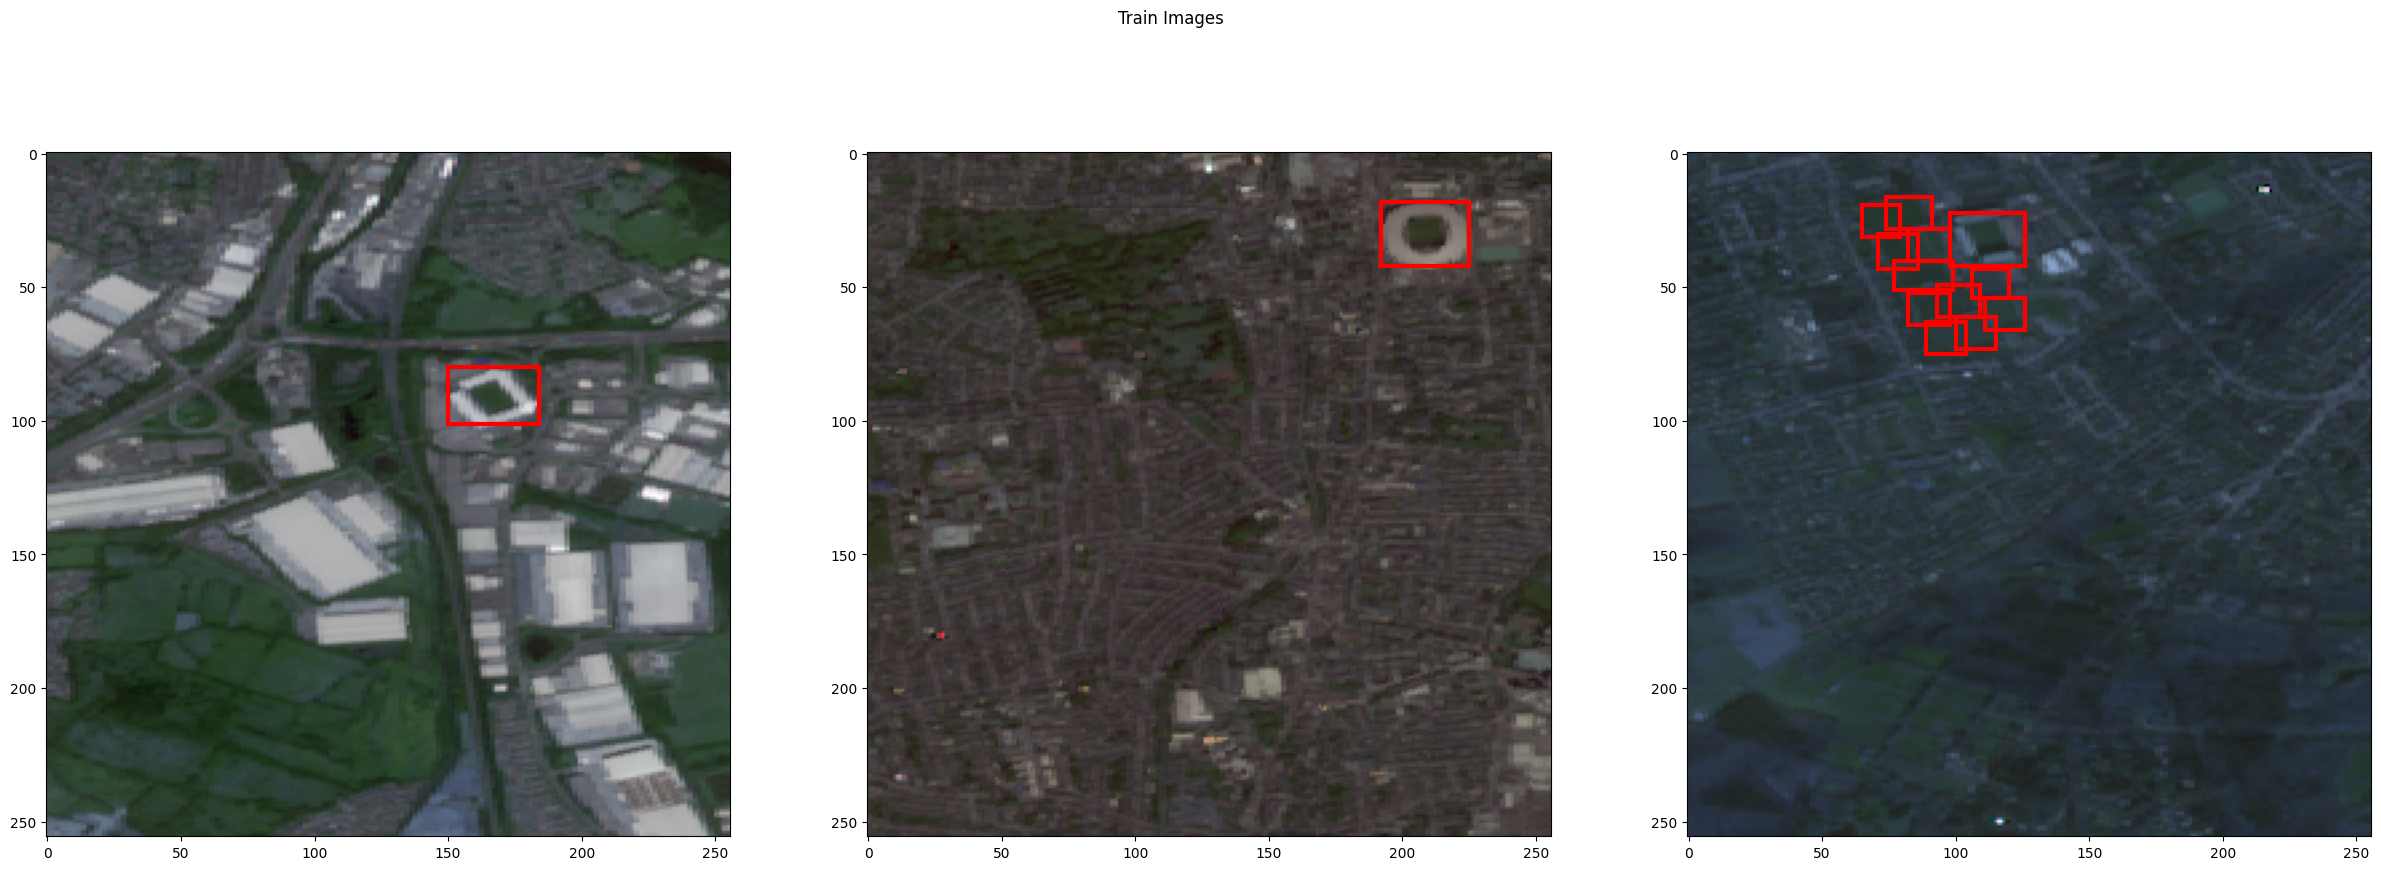

In [6]:
def plot_sample(sample, pred=None, ax=None, gamma=None):

    image = sample["image"].permute(1, 2, 0)[:, :, 0:3]

    if gamma is not None:
        image = image.pow(gamma)

    image = torch.flip(image, [2])

    bboxes = sample["bbox"].detach().numpy()

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig = ax.get_figure()

    ax.imshow(image)

    for bbox in bboxes:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            linewidth=3,
            edgecolor="red",
            facecolor="none",
        )

        ax.add_patch(rect)

    if pred is not None:
        for p in pred:
            boxes = p["boxes"].round().detach().cpu().numpy()
            scores = p["scores"].detach().cpu().numpy()
            for box, score in zip(boxes, scores):
                if score < 0.8:
                    continue

                ax.add_patch(
                    patches.Rectangle(
                        (box[0], box[1]),
                        box[2] - box[0],
                        box[3] - box[1],
                        linewidth=2,
                        edgecolor="blue",
                        facecolor="none",
                    )
                )


vis_gamma = 0.5

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle("Train Images")

plot_sample(dataset[0], ax=axes[0], gamma=vis_gamma)
plot_sample(dataset[1], ax=axes[1], gamma=vis_gamma)
plot_sample(dataset[2], ax=axes[2], gamma=vis_gamma)

A custom collate function is required to fit the data samples to a format that the `torchgeo` object detection task expects.  

In [7]:
def collate_fn(batch):
    batch = {
        "image": torch.stack([i["image"] for i in batch]).float(),
        "boxes": ([i["bbox"].float() for i in batch]),
        "labels": [i["label"].long() for i in batch],
    }

    return batch


dataloader = DataLoader(
    dataset, batch_size=4, collate_fn=collate_fn, num_workers=14, shuffle=True
)

The model selected for this task is a Faster RCNN network with a standard ResNet18 backbone. It is the smallest backbone available in the `torchgeo` implementation but is more than enough for this task. The `loss_box_reg` metric is also selected to be monitored for the learning rate scheduler. This metric tracks how well the final predicted bounding boxes overlap with the ground truth bounding boxes. It doesn't take the predicted class into account.

In [8]:
task = ObjectDetectionTask(
    model="faster-rcnn",
    backbone="resnet18",
    weights=True,
    in_channels=3,
    num_classes=3,
    lr=1e-4,
)

task.monitor = "loss_box_reg"

In [9]:
accelerator = "cuda" if torch.cuda.is_available() else "cpu"

trainer = pl.Trainer(
    accelerator=accelerator,
    min_epochs=1,
    max_epochs=50,
    log_every_n_steps=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Training Model

Training the model for 50 epochs and with a batch size of four on a NVIDIA RTX 3050 laptop GPU takes about ~20-25 minutes.

If running locally, `tensorboard` can be used to track the training progress. 

In [10]:
trainer.fit(task, dataloader)

model = task.model.eval().to(accelerator)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | FasterRCNN       | 28.3 M | train
1 | val_metrics  | MetricCollection | 0      | train
2 | test_metrics | MetricCollection | 0      | train
----------------------------------------------------------
28.1 M    Trainable params
156 K     Non-trainable params
28.3 M    Total params
113.116   Total estimated model params size (MB)
110       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


With a trained model we can first verify that it works well on the training set. 

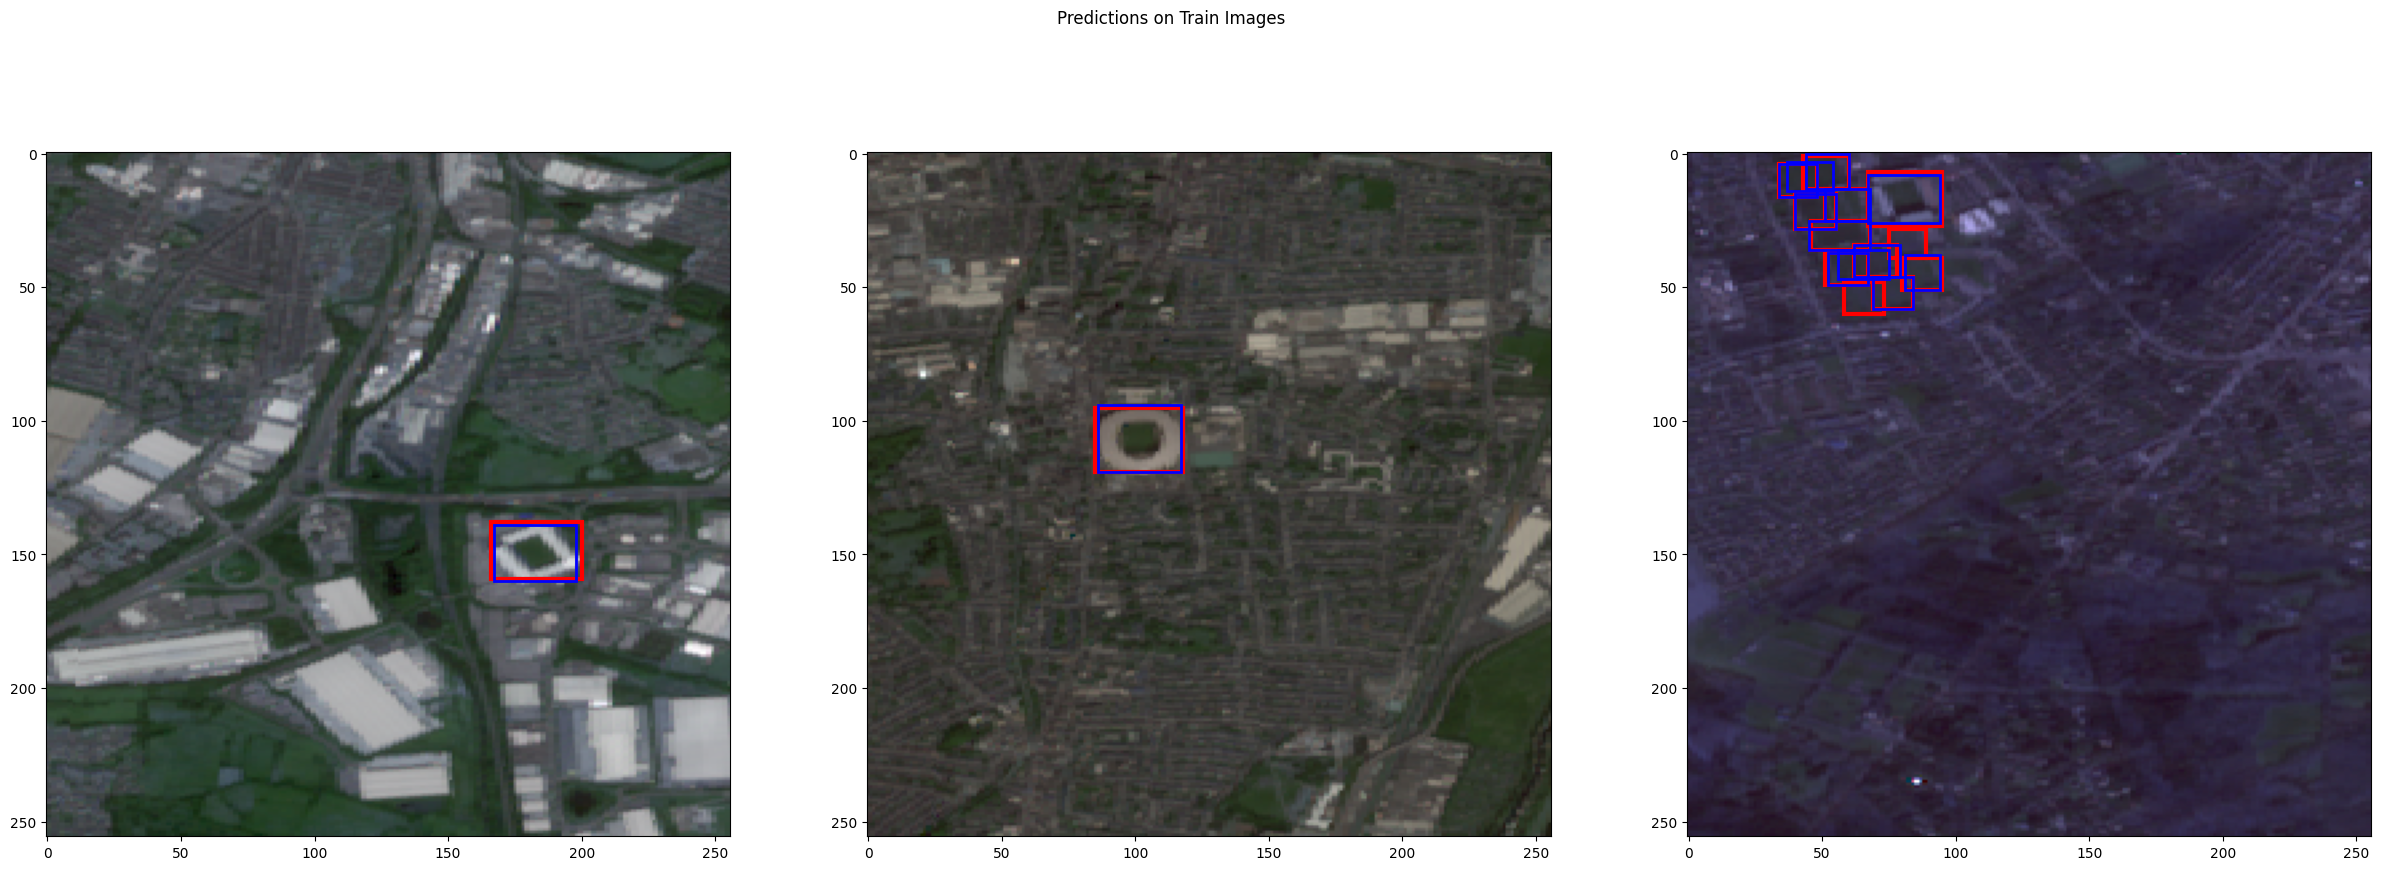

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle("Predictions on Train Images")

dataset_indexes = [0, 1, 2]

samples = [dataset[x] for x in dataset_indexes]

pred1 = model(samples[0]["image"].unsqueeze(0).to(accelerator))
pred2 = model(samples[1]["image"].unsqueeze(0).to(accelerator))
pred3 = model(samples[2]["image"].unsqueeze(0).to(accelerator))

plot_sample(samples[0], ax=axes[0], pred=pred1, gamma=vis_gamma)
plot_sample(samples[1], ax=axes[1], pred=pred2, gamma=vis_gamma)
plot_sample(samples[2], ax=axes[2], pred=pred3, gamma=vis_gamma)

### Testing on New Imagery

Running the model on the training data is not that intresting, so we need new data to really see how well it performs. Therefore we use the previously used  `download_sentinel2_tiles` function to download some new imagery. The frame below downloads three new tiles in areas not covered by the training data, the downtown areas of Stockholm, Lissabon and Berlin.

In [12]:
test_gdf = gpd.GeoDataFrame(
    [
        {
            "name": "Lissabon",
            "geometry": Polygon(
                [
                    (-9.161176746212165, 38.723705626931995),
                    (-9.165176746212165, 38.724705626931995),
                    (-9.160176746212165, 38.720705626931995),
                ],
            ),
        },
        {
            "name": "Berlin",
            "geometry": Polygon(
                [
                    (13.428662304911857, 52.50638628336037),
                    (13.420662304911857, 52.50038628336037),
                    (13.429662304911857, 52.50938628336037),
                ],
            ),
        },
        {
            "name": "Stockholm",
            "geometry": Polygon(
                [
                    (18.060318095013706, 59.31701036389577),
                    (18.070318095013706, 59.35701036389577),
                    (18.050318095013706, 59.30701036389577),
                ],
            ),
        },
    ],
    crs="EPSG:4326",
)

# download_sentinel2_tiles(test_gdf, test_image_path, bands, buffer=6000)

### Tile Predictor

When running the model in prediction mode we cannot reuse the previously implemented custom dataset, since now we don't know the locations of the stadiums before hand. Therefore we use this `TilePredictor` class which is designed to perform object detection on large geospatial TIFF images using a deep learning model. It divides the image into smaller tiles, processes each tile by normalizing its pixel values, and feeds the data into the model for prediction. The model outputs bounding boxes, labels, and confidence scores for detected objects, and only predictions that meet a defined confidence threshold are retained.

A key feature of this class is its ability to map the predicted bounding boxes from pixel space to real-world geographic coordinates (EPSG:4326). The final output is a GeoDataFrame with object locations tied to actual geographic points, making the predictions suitable for further geospatial analysis. This approach allows for efficient, large-scale object detection on satellite imagery while preserving spatial context.

In [13]:
class TiffPredictor:
    def __init__(self, model, tile_size: int = 256, score_threshold: float = 0.75):
        self._model = model
        self._tile_size = tile_size
        self._score_threshold = score_threshold

    @staticmethod
    def min_max_strech(data):
        image = data.astype(np.float32)

        image - np.min(image, axis=(1, 2), keepdims=True)
        image /= np.max(image, axis=(1, 2), keepdims=True)

        return image

    def predict_on_tile(self, ds, x, y):
        tile_coord_x = self._tile_size * x
        tile_coord_y = self._tile_size * y

        window = rio.windows.Window(
            row_off=tile_coord_y,
            col_off=tile_coord_x,
            width=self._tile_size,
            height=self._tile_size,
        )

        data = ds.read([1, 2, 3], window=window)

        image = torch.from_numpy(self.min_max_strech(data)).unsqueeze(0).cuda()

        pred = model(image)

        # Map predictions to the datasets spatial coordinates
        predictions = []
        for box, score, label in zip(
            pred[0]["boxes"], pred[0]["scores"], pred[0]["labels"]
        ):
            if score < self._score_threshold:
                continue

            # Convert local coordinates to spatial coordinates (EPSG:4326)
            x_ds_min = window.col_off + box[0].item()
            y_ds_min = window.row_off + box[1].item()

            x_ds_max = window.col_off + box[2].item()
            y_ds_max = window.row_off + box[3].item()

            lon_min, lat_min = ds.xy(y_ds_min, x_ds_min)
            lon_max, lat_max = ds.xy(y_ds_max, x_ds_max)

            predictions.append(
                {
                    "bbox": [lon_min, lat_min, lon_max, lat_max],
                    "score": score.item(),
                    "label": label.item(),
                }
            )

        return {"predictions": predictions, "image": image}

    def predict_tiff(self, tiff_path: Path):

        ds = rio.open(tiff_path)

        preds = []

        for tile_idx_x in range(ds.width // self._tile_size):
            for tile_idx_y in range(ds.height // self._tile_size):
                preds.extend(
                    self.predict_on_tile(ds, tile_idx_x, tile_idx_y)["predictions"]
                )

        for pred in preds:
            pred.update({"geometry": box(*pred["bbox"])})
            pred.pop("bbox")

        return gpd.GeoDataFrame(preds, crs="EPSG:4326")

    def __call__(self, *args, **kwargs):
        return self.predict_tiff(*args, **kwargs)


predictor = TiffPredictor(model)

### Running Model on New Imagery

In [14]:
predictions = []

tiff_images = [x for x in test_image_path.iterdir() if x.suffix == ".tif"]

for tiff_path in tqdm(tiff_images, total=len(tiff_images)):

    predictions.append(predictor(tiff_path))

predictions = pd.concat(predictions)
print(f"Number of predictions:\t{predictions.shape[0]}")

explore_sentinel2(predictions, bands, "Model Predictions")

100%|██████████| 3/3 [00:07<00:00,  2.66s/it]


Number of predictions:	51


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Results

* **Lisabon**: All but one of the predictions are valid stadiums. The single false positive is in a park with a deceptive trail around the edge of a oval area. It is clear why the model mistook this for a stadium.
* **Berlin**: More predictions overall in Berlin than in Lisabon. Again the model does a good job, a clear majority, about 90 % are valid stadiums. Two squared shaped buildings are false positives. It is however clear in this scene that the model is not too confident in predicting and finding smaller football pitches. This is expected since only a few such samples exits in the training data and there are some such pitches that haven't been annotated in the training images.
* **Stockholm**: The model seems to perform a bit worse in this scene, about 60-70 % of predictions are true positives. Intrestingly several false positives are small islands with oval or round shapes. Also an intresting false example is in the north east part of the city where a large rectangular pool in the harbour has been classified as a stadium. 



## Conclusion

As can be seen in the map above, the model performs remarkably well given its simplicity. Approximately 80-90% of its predictions are true positives, and it successfully identifies the largest stadiums in most cities. However, it does show some difficulty with smaller stadiums, which is expected given the training set consisted of only around 130 samples. Still, the overall results are impressive. The model's performance in Stockholm, where it produced several false positives near water, suggests that including more training samples from similar coastal areas could improve accuracy. Additionally, the model occasionally misinterprets green areas with circular or rectangular walkways or roads as stadium structures, likely confusing these shapes with the stands surrounding an arena.

The most striking takeaway from this exercise is just how accessible machine learning has become, even for relatively new practitioners. Object detection, once a highly specialized field, has advanced to the point where building a functional model with a new dataset is surprisingly straightforward. With powerful open-source tools and readily available data, the barrier to entry has been lowered dramatically, allowing anyone with an interest to experiment and achieve meaningful results in machine learning with minimal complexity.

So, the answer to this notebooks initial question —__is it possible to detect stadiums in Sentinel 2 RGB data__— is a resounding yes!
